Reliability/Survival Analysis and Football Goals

Section 1: Data overview of Statsbombpy 
Section 2: Goal modelling and Independence Problems
Section 3: Reliability Modelling and Results

A quick overview of what data statsbombpy can provide. It will only use the free data available, but the code can easily be adapted to the paid material if you have a subscription. 

Mostly following the official documentation, you can see if on github

In [1]:
import pandas as pd
from statsbombpy import sb
import copy
import warnings
warnings.filterwarnings("ignore", module="statsbombpy")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = sb.competitions()
# here I just assign to a dataframe because I am more used to manipulating it this way

In [3]:
df.competition_name.unique()
# a quick look at whats available

array(['1. Bundesliga', 'African Cup of Nations', 'Champions League',
       'Copa del Rey', "FA Women's Super League", 'FIFA U20 World Cup',
       'FIFA World Cup', 'Indian Super league', 'La Liga',
       'Liga Profesional', 'Ligue 1', 'Major League Soccer',
       'North American League', 'NWSL', 'Premier League', 'Serie A',
       'UEFA Euro', 'UEFA Europa League', "UEFA Women's Euro",
       "Women's World Cup"], dtype=object)

In [4]:
epl_df = df[df['competition_name'] == 'Premier League'].copy()
# lets use the EPL

In [5]:
epl_df.head()

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
63,2,27,England,Premier League,male,False,False,2015/2016,2024-01-25T11:45:53.333860,2021-06-13T16:17:31.694,None,2024-01-25T11:45:53.333860
64,2,44,England,Premier League,male,False,False,2003/2004,2024-03-08T14:49:13.195793,2021-06-13T16:17:31.694,None,2024-03-08T14:49:13.195793


In [6]:
epl_1516 = sb.matches(competition_id=2, season_id=27)
# pick the latest season 15/16. This was the season in which Leicester City won the league

In [7]:
epl_1516.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   match_id               380 non-null    int64 
 1   match_date             380 non-null    object
 2   kick_off               380 non-null    object
 3   competition            380 non-null    object
 4   season                 380 non-null    object
 5   home_team              380 non-null    object
 6   away_team              380 non-null    object
 7   home_score             380 non-null    int64 
 8   away_score             380 non-null    int64 
 9   match_status           380 non-null    object
 10  match_status_360       380 non-null    object
 11  last_updated           380 non-null    object
 12  last_updated_360       380 non-null    object
 13  match_week             380 non-null    int64 
 14  competition_stage      380 non-null    object
 15  stadium                

In [27]:
epl_1516.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3754058,2016-01-02,16:00:00.000,England - Premier League,2015/2016,Leicester City,AFC Bournemouth,0,0,available,...,2021-06-12T16:17:31.694,20,Regular Season,King Power Stadium,Andre Marriner,Claudio Ranieri,Eddie Howe,1.1.0,2,2
1,3754245,2015-10-17,16:00:00.000,England - Premier League,2015/2016,West Bromwich Albion,Sunderland,1,0,available,...,2021-06-13T16:17:31.694,9,Regular Season,The Hawthorns,Martin Atkinson,Tony Pulis,Sam Allardyce,1.1.0,2,2
2,3754136,2015-12-19,18:30:00.000,England - Premier League,2015/2016,Newcastle United,Aston Villa,1,1,available,...,2021-06-13T16:17:31.694,17,Regular Season,St. James'' Park,Martin Atkinson,Steve McClaren,Rémi Garde,1.1.0,2,2
3,3754037,2016-04-30,16:00:00.000,England - Premier League,2015/2016,Everton,AFC Bournemouth,2,1,available,...,2021-06-12T16:17:31.694,36,Regular Season,Goodison Park,Neil Swarbrick,Roberto Martínez Montoliú,Eddie Howe,1.1.0,2,2
4,3754039,2016-02-13,16:00:00.000,England - Premier League,2015/2016,Crystal Palace,Watford,1,2,available,...,2021-06-12T16:17:31.694,26,Regular Season,Selhurst Park,Robert Madley,Alan Pardew,Enrique Sánchez Flores,1.1.0,2,2


In [26]:
epl_1516_matches = epl_1516.match_id.unique()
#epl_1516_matches
# this is what match IDs look like. Just a simple integer for reference

Most of this notebook hereafter will focus on Goals being scored. Some quick blocks to show how easily the information can be extracted.

In [10]:
test_match = epl_1516[epl_1516['match_id'] == epl_1516_matches[0]].copy()

In [11]:
print(test_match['home_team'].iloc[0],test_match['away_team'].iloc[0],test_match['home_score'].iloc[0],test_match['away_score'].iloc[0])

Leicester City AFC Bournemouth 0 0


In [12]:
home_team = test_match['home_team'].iloc[0]
away_team = test_match['away_team'].iloc[0]
home_score = test_match['home_score'].iloc[0]
away_score = test_match['away_score'].iloc[0]

Now, to the crux of the research. 

Lets examination the goals scored, and see if home goals and away goals are independent events. If so, we could model it easily using two poisson models. 

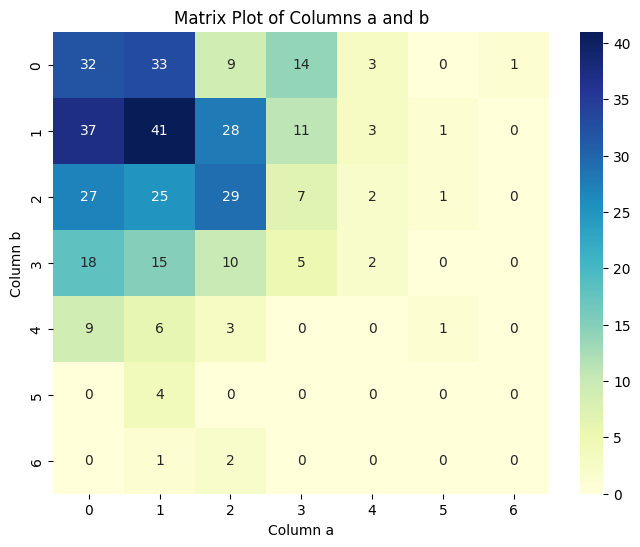

In [23]:
#just grab the goals scored columns
df_subset = epl_1516[['home_score', 'away_score']]

# Count occurrences of each combination of 'a' and 'b'
observed_matrix = df_subset.groupby(['home_score', 'away_score']).size().unstack(fill_value=0)

# Plotting using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(observed_matrix, annot=True, cmap='YlGnBu', fmt='d', cbar=True)

# Add labels and title
plt.title('Matrix Plot of Columns a and b')
plt.xlabel('Column a')
plt.ylabel('Column b')

plt.show()

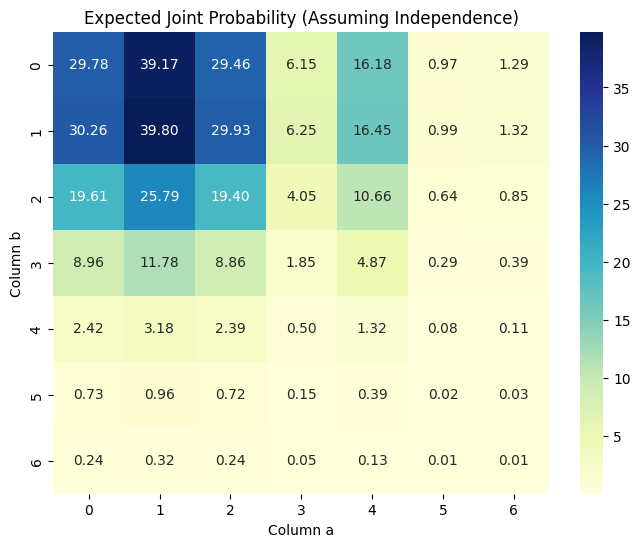

In [22]:
# Lets see what a Poisson model would look like
mean_a = df_subset['home_score'].mean()
mean_b = df_subset['away_score'].value_counts().mean()  

expected_matrix = np.outer(df_subset['away_score'].value_counts(sort=False), df_subset['home_score'].value_counts(sort=False)) / len(df_subset)


plt.figure(figsize=(8, 6))
sns.heatmap(expected_matrix, annot=True, cmap='YlGnBu', fmt='.2f', cbar=True)
plt.title('Expected Joint Probability (Assuming Independence)')
plt.xlabel('Column a')
plt.ylabel('Column b')

plt.show()

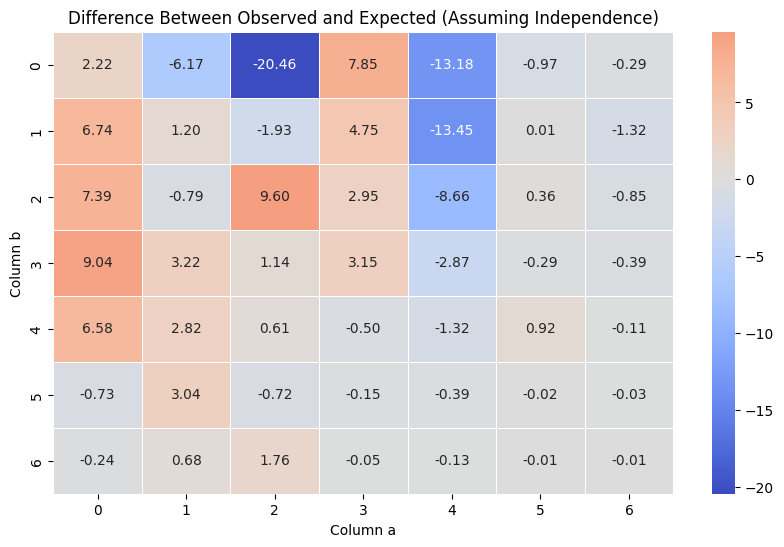

In [24]:
# Lets do a difference matrix
difference_matrix = observed_matrix - expected_matrix

plt.figure(figsize=(10, 6))
sns.heatmap(difference_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, center=0, linewidths=.5)
plt.title('Difference Between Observed and Expected (Assuming Independence)')
plt.xlabel('Column a')
plt.ylabel('Column b')
plt.show()

So there is a problem with concept of independence between the Home Goals and Away Goals. Lets dig a bit deeper into the individual matches to see what is going on. 

SB gives event data for each match. An example of the data available is shown below:

In [35]:
test_event = sb.events(epl_1516_matches[0])

In [36]:
test_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3576 entries, 0 to 3575
Data columns (total 90 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ball_receipt_outcome            156 non-null    object 
 1   ball_recovery_recovery_failure  7 non-null      object 
 2   carry_end_location              742 non-null    object 
 3   clearance_aerial_won            10 non-null     object 
 4   clearance_body_part             59 non-null     object 
 5   clearance_head                  33 non-null     object 
 6   clearance_left_foot             8 non-null      object 
 7   clearance_right_foot            18 non-null     object 
 8   counterpress                    121 non-null    object 
 9   dribble_nutmeg                  4 non-null      object 
 10  dribble_outcome                 31 non-null     object 
 11  dribble_overrun                 2 non-null      object 
 12  duel_outcome                    41

There are many fields. The ones of interest are the time related fields, and the goal related fields.

In [37]:
test_event.shot_outcome.unique()

array([nan, 'Blocked', 'Off T', 'Wayward', 'Post', 'Saved'], dtype=object)

In [38]:
test_event.period.unique()

array([1, 2], dtype=int64)

In [39]:
test_event.minute.unique()

array([ 0, 45,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 57], dtype=int64)

In [40]:
test_event.second.unique()

array([ 0,  1,  2,  3,  6,  9, 12, 15, 18, 22, 25, 30, 33, 39, 41, 55, 59,
        5,  8, 14, 19, 20, 23, 40, 43, 50,  7, 31, 34, 37, 45, 47,  4, 10,
       16, 48, 51, 54, 58, 49, 17, 24, 26, 27, 28, 32, 38, 56, 11, 29, 52,
       42, 36, 44, 53, 57, 35, 46, 13, 21], dtype=int64)

In [41]:
test_event.type.unique()
# what is not in the sample space below are the own goal fields. For matches with own goals, there will be a entry 'Own Goal For' 

array(['Starting XI', 'Half Start', 'Pass', 'Ball Receipt*', 'Carry',
       'Pressure', 'Dispossessed', 'Duel', 'Shot', 'Block', 'Goal Keeper',
       'Ball Recovery', 'Miscontrol', 'Clearance', 'Dribbled Past',
       'Dribble', 'Interception', 'Foul Committed', 'Foul Won',
       'Half End', 'Substitution', 'Injury Stoppage', 'Tactical Shift',
       'Shield'], dtype=object)

Lets simplify the dataframe. We could keep the timestamp field instead, but the minute and second is good enough for our analysis

In [42]:
columns_to_keep= ['team','shot_outcome','period','minute','second','type']

In [43]:
test_event_2 = test_event[columns_to_keep].copy()

In [44]:
test_event_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3576 entries, 0 to 3575
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   team          3576 non-null   object
 1   shot_outcome  27 non-null     object
 2   period        3576 non-null   int64 
 3   minute        3576 non-null   int64 
 4   second        3576 non-null   int64 
 5   type          3576 non-null   object
dtypes: int64(3), object(3)
memory usage: 167.8+ KB


Now we do some manipulation get elapsed match time, which accounts for extra time in the first half. Else we will end up with shots taken in 45+1 being in the same category as 46 (second half)

In [45]:
test_event_2['actual_time'] = test_event_2['minute'] + test_event_2['second'] /60

In [46]:
test_event_2.head()

,team,shot_outcome,period,minute,second,type,actual_time
0,Leicester City,NaN,1,0,0,Starting XI,0
1,AFC Bournemouth,NaN,1,0,0,Starting XI,0
2,AFC Bournemouth,NaN,1,0,0,Half Start,0
3,Leicester City,NaN,1,0,0,Half Start,0
4,AFC Bournemouth,NaN,2,45,0,Half Start,45


In [47]:
first_half_increment = test_event_2.loc[test_event_2['period'] == 1, 'actual_time'].max() - 45
first_half_increment

1.1166666666666671

In [48]:
second_half_increment = test_event_2.loc[test_event_2['period'] == 2, 'actual_time'].max() - 90
second_half_increment

4.63333333333334

In [49]:
test_event_2.loc[test_event_2['period'] == 2, 'actual_time'] += first_half_increment

In [50]:
final_time = test_event_2['actual_time'].max()
final_time

95.75

Now a simple manipulation to only keep the goal related rows

In [51]:
test_event_2 = test_event_2[(test_event_2['shot_outcome'] == 'Goal')|(test_event_2['type'] == 'Own Goal For')]

In [52]:
test_event_2.sort_values(by='actual_time', inplace=True)
test_event_2

,team,shot_outcome,period,minute,second,type,actual_time


Since it was a 0-0 match, this is expected

This is the basis of what we will do for every match that we have.

a) keep track of the overall distribution of goals vs time

b) keep track of elapsed time between goals (eg start time to first goal, first to second.... last goal to end of match)

In [53]:
def process_rows(df,home_team,away_team,home_score,away_score,final_time):
    temp_list = []
    home_goals = 0
    away_goals = 0
    goal_time_last = 0
    current_state = [home_goals,away_goals]
    for index, row in df.iterrows():
        scoring_team = row['team']
        scoring_time = row['actual_time']
        if scoring_team == home_team:
            home_goals += 1
        elif scoring_team == away_team:
            away_goals += 1
        else:
            print("WHOSCORED??", row)
        new_state = [home_goals,away_goals]
        elapsed_time = scoring_time - goal_time_last
        temp_list.append([current_state,new_state,elapsed_time])
        goal_time_last = scoring_time
        current_state = new_state
    elapsed_time = final_time - goal_time_last
    temp_list.append([current_state,current_state,elapsed_time])
    if home_goals != home_score or away_goals != away_score:
        print("checksum error")
        print(home_team,home_score)
        print(away_team, away_score)
        print(df)
    return temp_list



In [54]:
new_list = process_rows(test_event_2,home_team,away_team,home_score,away_score,final_time)
new_list

[[[0, 0], [0, 0], 95.75]]

In [55]:
reference_dict = {}
reference_dict[epl_1516_matches[0]]=new_list

In [56]:
reference_dict

{3754058: [[[0, 0], [0, 0], 95.75]]}

You can see what the function does based on the match. 

Start state, stop state, and time elapsed between them goes into the list. After that it becomes the value for the key (match_id)

Lets run this for the entire match list

In [57]:
reference_dict = {}
master_list = []
for match in epl_1516_matches:
    test_match = epl_1516[epl_1516['match_id'] == match].copy()
    home_team = test_match['home_team'].iloc[0]
    away_team = test_match['away_team'].iloc[0]
    home_score = test_match['home_score'].iloc[0]
    away_score = test_match['away_score'].iloc[0]
    
    test_event = sb.events(match)
    test_event_2 = test_event[columns_to_keep].copy()
    test_event_2['actual_time'] = test_event_2['minute'] + test_event_2['second'] /60
    first_half_increment = test_event_2.loc[test_event_2['period'] == 1, 'actual_time'].max() - 45
    test_event_2.loc[test_event_2['period'] == 2, 'actual_time'] += first_half_increment
    final_time = test_event_2['actual_time'].max()
    #test_event_2 = test_event_2[test_event_2['shot_outcome'] == 'Goal']
    test_event_2 = test_event_2[(test_event_2['shot_outcome'] == 'Goal')|(test_event_2['type'] == 'Own Goal For')]
    test_event_2.sort_values(by='actual_time', inplace=True)
    
    master_list.extend(test_event_2['minute'].tolist())
    
    new_list = process_rows(test_event_2,home_team,away_team,home_score,away_score,final_time)
    reference_dict[match] = new_list
    

No errors were picked up by our function, quick check to make sure

In [58]:
len(reference_dict.keys())

380

TIme for a histogram showing the goals over the time period

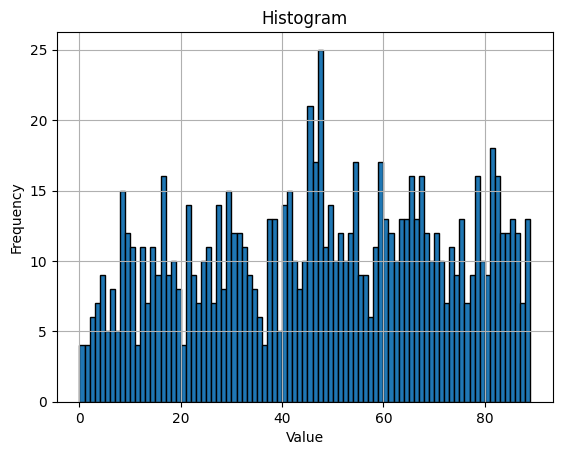

In [59]:
bins = list(range(0, 90)) + [float('inf')]  # Bins of width 1 up to 90, and the last bin for values greater than 90

# Plot histogram with custom bins
plt.hist(master_list, bins=bins, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.grid(True)
plt.show()

In [60]:
from reliability.Fitters import Fit_Weibull_2P
import matplotlib.pyplot as plt

Broadly it looks a bit random, with maybe a slight increase as the match time goes on.

The bigger problem is how to account for the extra time minutes. 

Not every match has the same number of extra time, so we can't just put it in the separate category and compare it to others.

Lets apply instead reliability/survivability analysis, looking at the time between events. 

In [61]:
def get_any_timings(reference_dict):
    fail = []
    sus_fail = []
    for keys,values in reference_dict.items():
        #print(reference_dict[keys])
        for entry_in in reference_dict[keys]:
            #print(entry_in)
            
            if entry_in[0] == entry_in[1]:
                sus_fail.append(entry_in[2])
            else:
                fail.append(entry_in[2])
                    
    return fail, sus_fail

amal_fail, amal_sus = get_any_timings(reference_dict)

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 1026/380 (27.02703% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         35.9528        0.994019   34.0564   37.9548
     Beta         1.13242        0.027763    1.0793   1.18817 

Goodness of fit    Value
 Log-likelihood -4682.15
           AICc  9368.31
            BIC  9378.79
             AD  124.849 



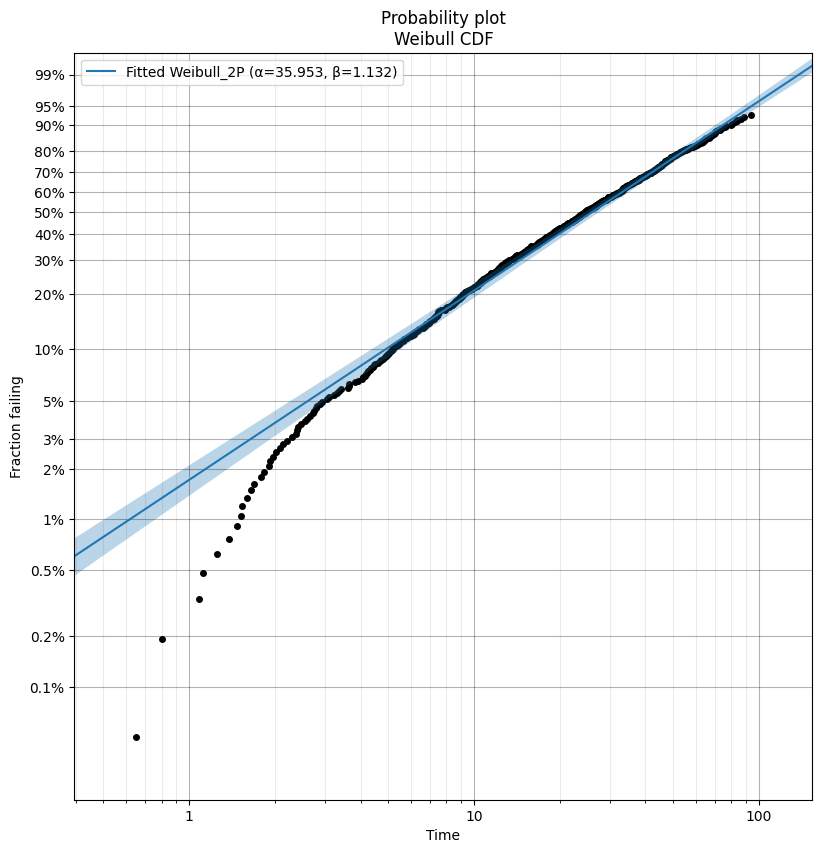

In [62]:
wb = Fit_Weibull_2P(failures=amal_fail,right_censored=amal_sus)
plt.show()

Some thing is not quite right with our amalgamated model. Lets break it down by start state (eg 0-0, 1-0, 0-1....) and by home/away goals

In [63]:
def get_timings(reference_dict,start_state = [0,0]):
    home_fail = []
    away_fail = []
    sus_fail = []
    end_home = copy.deepcopy(start_state)
    end_home[0] += 1
    end_away = copy.deepcopy(start_state)
    end_away[1] += 1
    print(start_state, end_home,end_away)
    for keys,values in reference_dict.items():
        #print(reference_dict[keys])
        for entry_in in reference_dict[keys]:
            #print(entry_in)

            if entry_in[0] == start_state:
                if entry_in[1] == end_home:
                    home_fail.append(entry_in[2])
                elif entry_in[1] == end_away:
                    away_fail.append(entry_in[2])
                else:
                    sus_fail.append(entry_in[2])
                    
    return home_fail, away_fail, sus_fail

In [64]:
home_fail, away_fail, sus_fail = get_timings(reference_dict,start_state = [0,0])
print(len(home_fail),len(away_fail),len(sus_fail))

[0, 0] [1, 0] [0, 1]
196 152 32


lets see how 0-0 works out

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 348/32 (8.42105% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         42.3197         1.99978   38.5762   46.4264
     Beta         1.16118       0.0509652   1.06546   1.26549 

Goodness of fit    Value
 Log-likelihood -1634.76
           AICc  3273.55
            BIC   3281.4
             AD  60.7791 



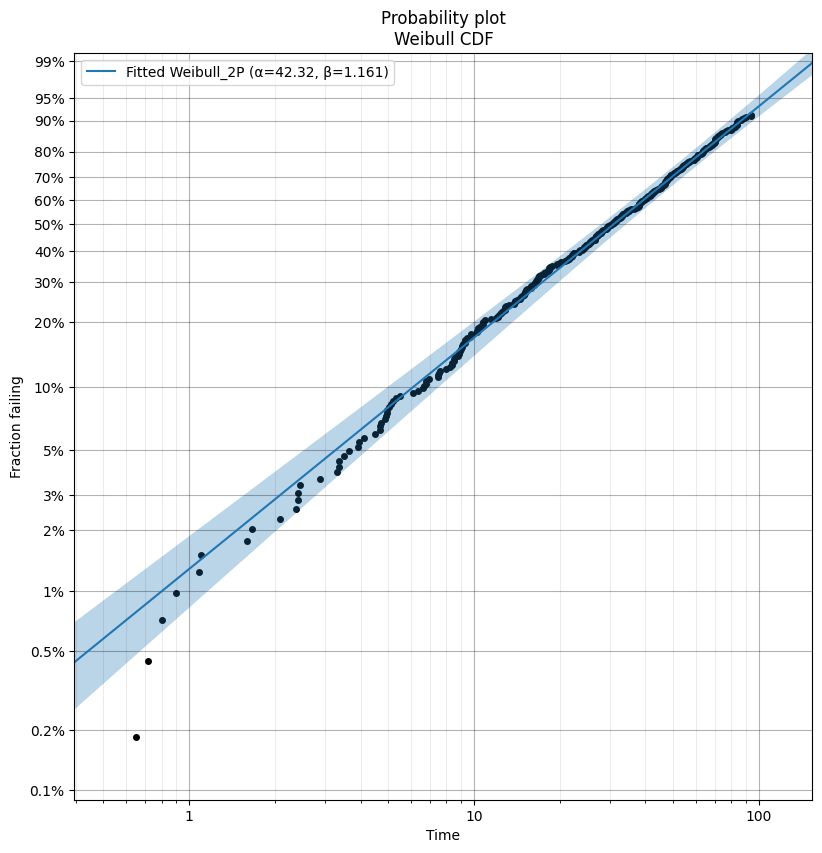

In [65]:
merged_list = away_fail + home_fail
wb = Fit_Weibull_2P(failures=merged_list,right_censored=sus_fail)
plt.show()

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 196/184 (48.42105% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         69.5176         4.44481   61.3296   78.7986
     Beta         1.15284       0.0675059   1.02784   1.29304 

Goodness of fit    Value
 Log-likelihood -1033.53
           AICc   2071.1
            BIC  2078.95
             AD  327.077 



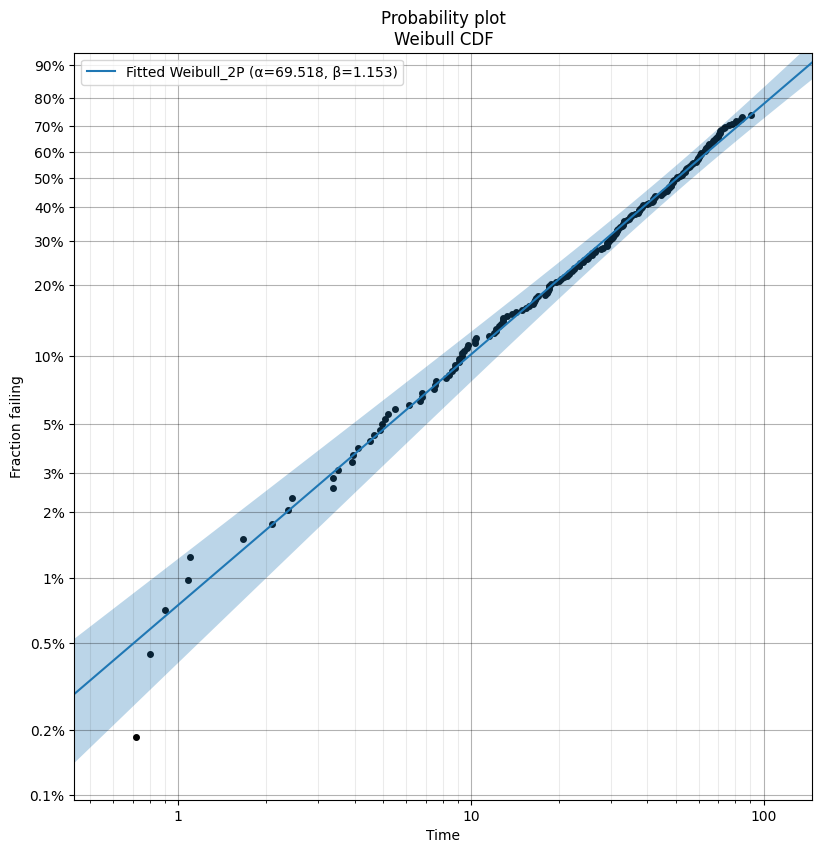

In [66]:
merged_list = away_fail + sus_fail
wb = Fit_Weibull_2P(failures=home_fail,right_censored=merged_list)
plt.show()

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 152/228 (60% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         85.9803         6.53744   74.0761   99.7974
     Beta         1.17208       0.0777149   1.02925   1.33474 

Goodness of fit    Value
 Log-likelihood -839.634
           AICc   1683.3
            BIC  1691.15
             AD  423.538 



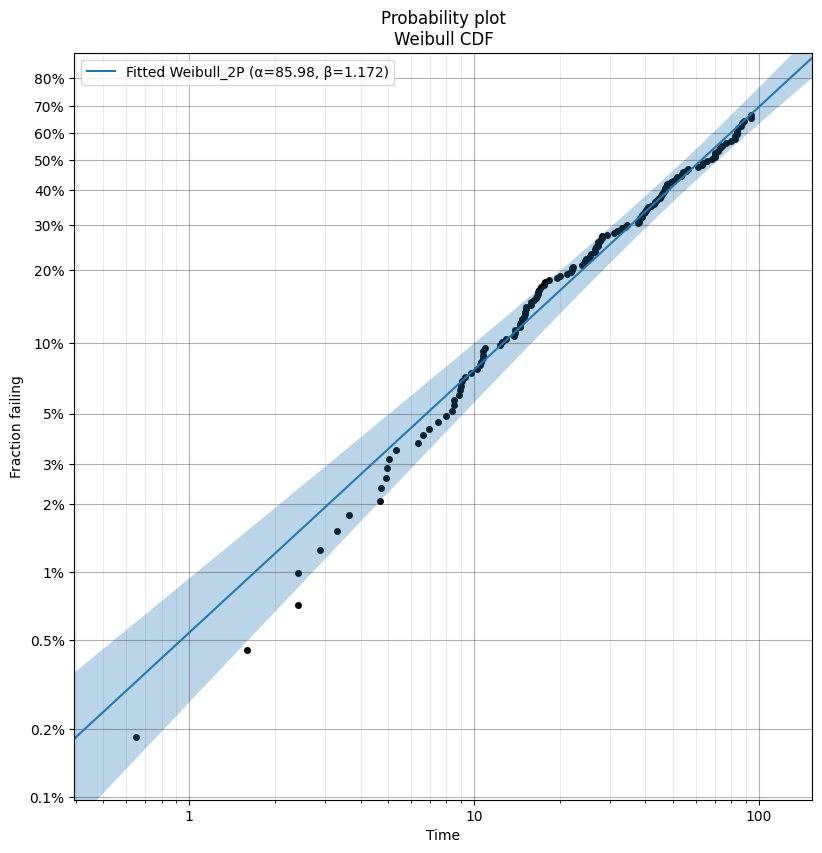

In [67]:
merged_list = home_fail + sus_fail
wb = Fit_Weibull_2P(failures=away_fail,right_censored=merged_list)
plt.show()

In [68]:
from reliability.Reliability_testing import likelihood_plot

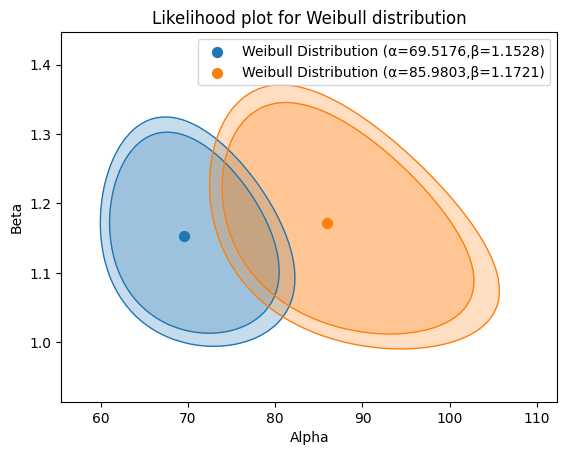

In [69]:
likelihood_plot(distribution="Weibull", failures=home_fail,right_censored=(away_fail+sus_fail), CI=[0.9, 0.95])
likelihood_plot(distribution="Weibull", failures=away_fail,right_censored=(home_fail+sus_fail), CI=[0.9, 0.95])
plt.show()

Our data performs much better when considering 0-0 start state only. 

Its not clear if home and away are distinct populations though.

There is very strong indication of random (beta = 1). In that case, we could conclude that they are distinct populations if we force the beta to be 1 for both populations. 

However lets do a quick check on a separate start state, when the home team leads 1-0

In [222]:
home_fail, away_fail, sus_fail = get_timings(reference_dict,start_state = [1,0])
print(len(home_fail),len(away_fail),len(sus_fail))

[1, 0] [2, 0] [1, 1]
96 63 37


Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 159/37 (18.87755% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha          33.704         2.33108   29.4313    38.597
     Beta         1.15399        0.074489   1.01685   1.30962 

Goodness of fit    Value
 Log-likelihood -713.788
           AICc  1431.64
            BIC  1438.13
             AD  23.7336 



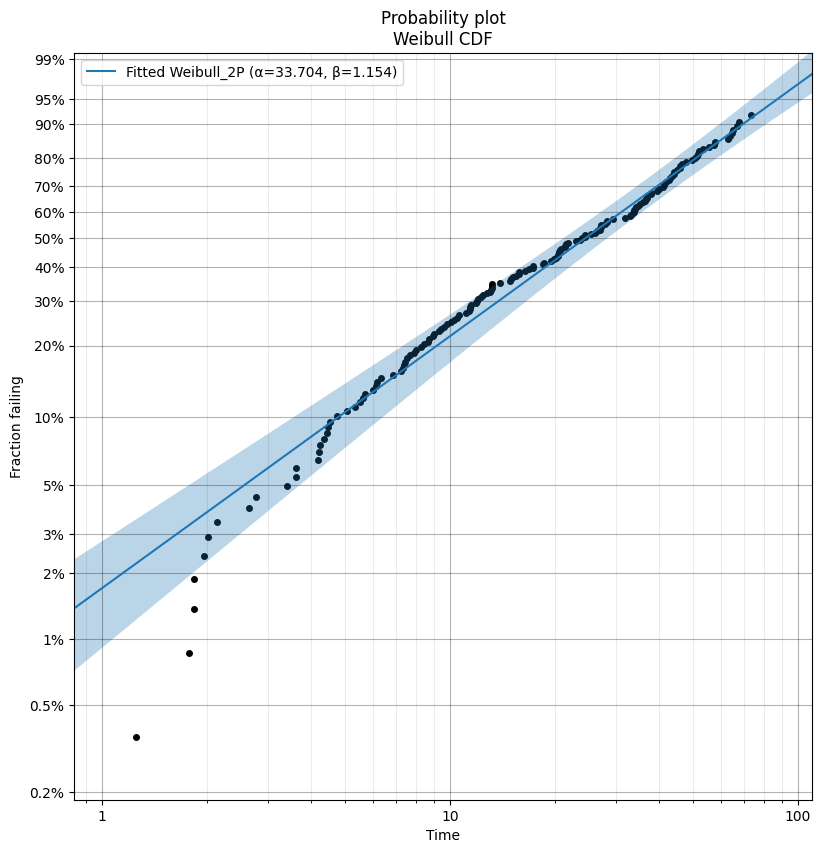

In [217]:
merged_list = away_fail + home_fail
wb = Fit_Weibull_2P(failures=merged_list,right_censored=sus_fail)
plt.show()

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 96/100 (51.02041% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         52.6359          5.0025   43.6902   63.4132
     Beta         1.12413       0.0938573  0.954439     1.324 

Goodness of fit    Value
 Log-likelihood -479.865
           AICc  963.792
            BIC  970.286
             AD  101.829 



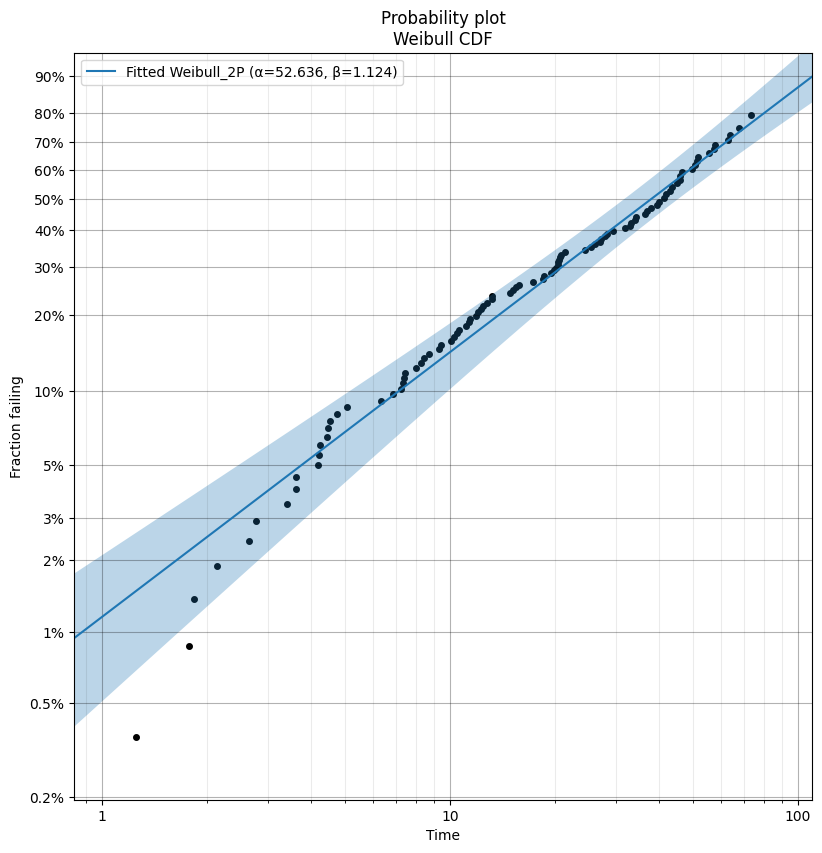

In [216]:
merged_list = away_fail + sus_fail
wb = Fit_Weibull_2P(failures=home_fail,right_censored=merged_list)
plt.show()

Results from Fit_Weibull_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 152/228 (60% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
    Alpha         85.9803         6.53744   74.0761   99.7974
     Beta         1.17208       0.0777149   1.02925   1.33474 

Goodness of fit    Value
 Log-likelihood -839.634
           AICc   1683.3
            BIC  1691.15
             AD  423.538 



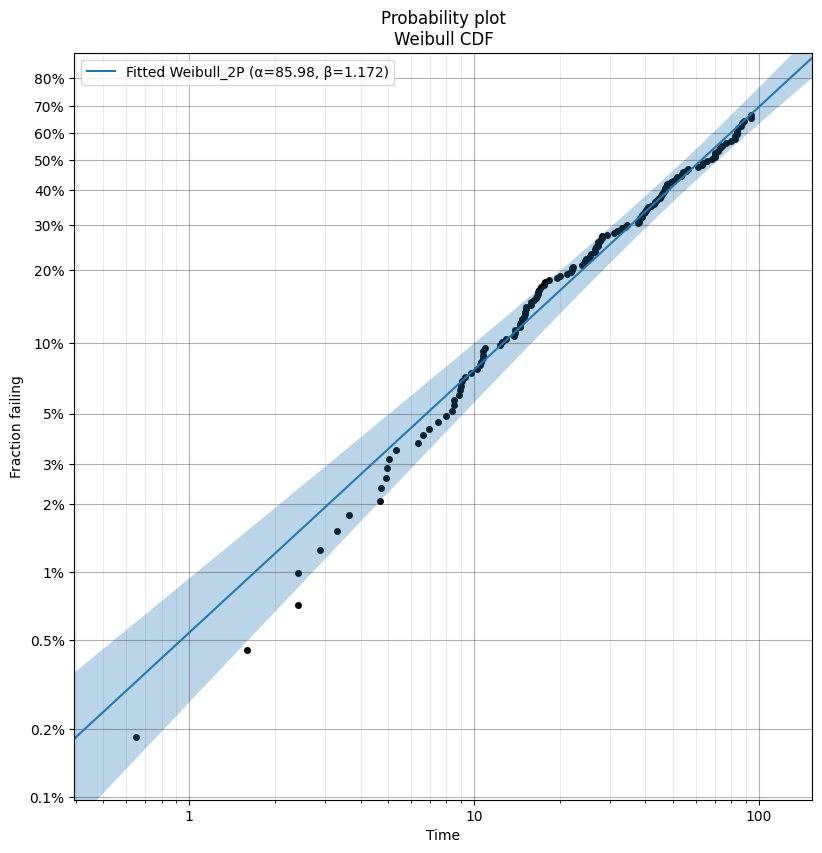

In [70]:
merged_list = home_fail + sus_fail
wb = Fit_Weibull_2P(failures=away_fail,right_censored=merged_list)
plt.show()

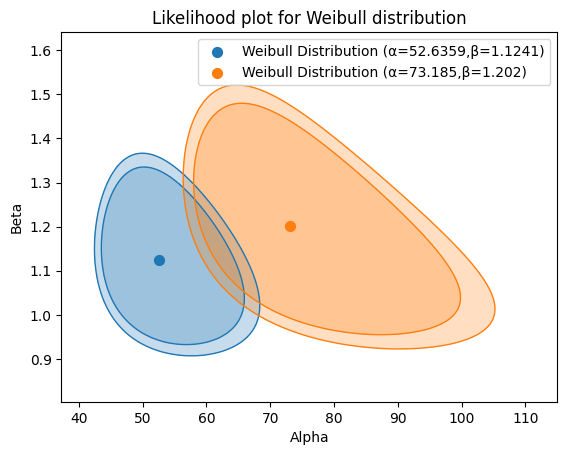

In [223]:
likelihood_plot(distribution="Weibull", failures=home_fail,right_censored=(away_fail+sus_fail), CI=[0.9, 0.95])
likelihood_plot(distribution="Weibull", failures=away_fail,right_censored=(home_fail+sus_fail), CI=[0.9, 0.95])
plt.show()

Again, the evidence is leaning more towards two distinct populations rather than 1. 

We could adopt a 3 parameter weibull to help wth the offset problem near 0. putting 8-10 seconds could help with the larger error seen there. 

Conclusion

Looking at the breakdown of the goals, reliability/survivalibility analysis can help to explain the frequency of goal distribution better than normal topdown models. It explains why modelling of independent Poisson distributions doesn't work well, and also correct the inherent flaws in histogram analysis.

However, the sample size of 1 season (380 matches) means that analysis becomes less reliable as goal sets increase. This is because there are far fewer matches at 2-2 than 0-0 for us to analyse. 

Further work could be done if more data was available. 

